# Megaline

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de los planes genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos. 

## ¿Cuál es la mejor tarifa?

In [1]:
# Load Python libraries 

import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as st
import numpy as np
import math as mt

# load 4 data sets:
users = pd.read_csv("megaline_users.csv") 
calls = pd.read_csv("megaline_calls.csv")
messages = pd.read_csv("megaline_messages.csv")
internet = pd.read_csv("megaline_internet.csv")
plans = pd.read_csv("megaline_plans.csv")

print(users.head(), users.info())
print(plans.head(), plans.info())
print(calls.head(), calls.info())
print(internet.head(), internet.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     1004    Leonila   Thompson   40        

In [8]:
# Transform & clean data Plans Dataframe df
plans['gb_per_month_included'] = plans['mb_per_month_included'] / 1000
plans_indexed = plans.set_index('plan_name')

#Enhance data
plans['cost_per_included_minute'] = plans['usd_monthly_pay'] / plans['minutes_included']
plans['cost_per_included_gb'] = plans['usd_monthly_pay'] / (plans['mb_per_month_included'] / 1000)

# Users df cleaning
users['reg_date'] = pd.to_datetime(users['reg_date'],format='%Y-%m-%d')
users['churn_date'] = users['churn_date'].fillna("Active client")

#categories [age_group] for users
users['subscription_days'] = (pd.to_datetime('2018-12-31') - users['reg_date']).dt.days
users['age_group'] = pd.cut(users['age'], 
                           bins=[0, 25, 35, 50, 100], 
                           labels=['Niñ@_joven', 'Adulto_joven', 'Adulto', 'Mayor'])

#Calls df cleaning
calls['call_date'] = pd.to_datetime(calls['call_date'],format='%Y-%m-%d')
calls['duration'] = np.ceil(calls['duration'])

# Calls df categories
calls['call_type'] = pd.cut(calls['duration'], 
                           bins=[0, 1, 5, 15, float('inf')], 
                           labels=['Muy_corta', 'Corta', 'Media', 'Larga'])

calls.groupby("call_type", observed=False)["call_type"].value_counts() 

# Messages df cleaning 
messages['message_date'] = pd.to_datetime(messages['message_date'],format='%Y-%m-%d')

# Messages categories
messages['month_period'] = pd.cut(messages['message_date'].dt.day, 
                                 bins=[0, 10, 20, 31], 
                                 labels=['Inicio', 'Medio', 'Final'])
daily_message_counts = messages.groupby(['user_id', messages['message_date'].dt.date]).size().reset_index(name='daily_messages')

# internet df cleaning
internet['session_date'] = pd.to_datetime(internet['session_date'],format='%Y-%m-%d')

# Correct unit 
internet['gb_used'] = internet['mb_used'] / 1000


In [9]:
# Verify transformed and clean data

print(users.head(), users.info())
print(plans.head(), plans.info())
print(calls.head(), calls.info())
print(internet.head(), internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            500 non-null    int64         
 1   first_name         500 non-null    object        
 2   last_name          500 non-null    object        
 3   age                500 non-null    int64         
 4   city               500 non-null    object        
 5   reg_date           500 non-null    datetime64[ns]
 6   plan               500 non-null    object        
 7   churn_date         500 non-null    object        
 8   subscription_days  500 non-null    int64         
 9   age_group          500 non-null    category      
dtypes: category(1), datetime64[ns](1), int64(3), object(5)
memory usage: 36.0+ KB
   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA

In [10]:
# Now aggregate the data by user and by period so that there is only one record per user and per period
# Calculate the number of calls made by each user per month

llamadas_usuarios_mes = calls.groupby(['user_id', calls['call_date'].dt.to_period('M')]).size()
print(llamadas_usuarios_mes)

user_id  call_date
1000     2018-12      16
1001     2018-08      27
         2018-09      49
         2018-10      65
         2018-11      64
                      ..
1498     2018-12      39
1499     2018-09      41
         2018-10      53
         2018-11      45
         2018-12      65
Length: 2258, dtype: int64


In [11]:
# Calculate the number of minutes used by each user per month
minutos_usuarios_mes = calls.groupby(['user_id', calls['call_date'].dt.to_period('M')])["duration"].sum()
print(minutos_usuarios_mes)

user_id  call_date
1000     2018-12      124.0
1001     2018-08      182.0
         2018-09      315.0
         2018-10      393.0
         2018-11      426.0
                      ...  
1498     2018-12      339.0
1499     2018-09      346.0
         2018-10      385.0
         2018-11      308.0
         2018-12      496.0
Name: duration, Length: 2258, dtype: float64


In [12]:
# Calculate the number of messages sent by each user per month

mensajes_usuarios_mes = messages.groupby(['user_id', messages['message_date'].dt.to_period('M')]).size()
print(mensajes_usuarios_mes)

user_id  message_date
1000     2018-12         11
1001     2018-08         30
         2018-09         44
         2018-10         53
         2018-11         36
                         ..
1496     2018-09         21
         2018-10         18
         2018-11         13
         2018-12         11
1497     2018-12         50
Length: 1806, dtype: int64


In [13]:
# Calculate the volume of Internet traffic used by each user per month

gb_usuarios_mes = internet.groupby(['user_id', internet['session_date'].dt.to_period('M')])["gb_used"].sum()
print(gb_usuarios_mes)

user_id  session_date
1000     2018-12          1.90147
1001     2018-08          6.91915
         2018-09         13.31482
         2018-10         22.33049
         2018-11         18.50430
                           ...   
1498     2018-12         23.13769
1499     2018-09         12.98476
         2018-10         19.49243
         2018-11         16.81383
         2018-12         22.05921
Name: gb_used, Length: 2277, dtype: float64


In [14]:
# Merges data from calls, minutes, messages, and internet based on user_id and month

consumo_completo = pd.concat([
    llamadas_usuarios_mes.rename('llamadas'),
    minutos_usuarios_mes.rename('minutos'), 
    mensajes_usuarios_mes.rename('mensajes'),
    gb_usuarios_mes.rename('gb_usados')
], axis=1)
consumo_completo.head()


llamadas  minutos  mensajes  gb_usados
user_id                                                
1000    2018-12      16.0    124.0      11.0    1.90147
1001    2018-08      27.0    182.0      30.0    6.91915
        2018-09      49.0    315.0      44.0   13.31482
        2018-10      65.0    393.0      53.0   22.33049
        2018-11      64.0    426.0      36.0   18.50430

In [15]:
# Add the fare info

consumo_completo_plan = consumo_completo.reset_index().merge(
    users[['user_id', 'plan',"city"]], 
    on='user_id', 
    how="left"
)
consumo_completo_plan = consumo_completo_plan.rename(columns={"level_1": "mes"})
consumo_completo_plan = consumo_completo_plan.merge(
    plans, 
    left_on='plan',  # columna en consumo_completo_plan para la fusion
    right_on='plan_name',  # columna en plans activa para la fusion 
    how='left'
)
print(consumo_completo_plan.head())

   user_id      mes  llamadas  minutos  mensajes  gb_usados      plan  \
0     1000  2018-12      16.0    124.0      11.0    1.90147  ultimate   
1     1001  2018-08      27.0    182.0      30.0    6.91915      surf   
2     1001  2018-09      49.0    315.0      44.0   13.31482      surf   
3     1001  2018-10      65.0    393.0      53.0   22.33049      surf   
4     1001  2018-11      64.0    426.0      36.0   18.50430      surf   

                                    city  messages_included  \
0  Atlanta-Sandy Springs-Roswell, GA MSA               1000   
1        Seattle-Tacoma-Bellevue, WA MSA                 50   
2        Seattle-Tacoma-Bellevue, WA MSA                 50   
3        Seattle-Tacoma-Bellevue, WA MSA                 50   
4        Seattle-Tacoma-Bellevue, WA MSA                 50   

   mb_per_month_included  minutes_included  usd_monthly_pay  usd_per_gb  \
0                  30720              3000               70           7   
1                  15360        

In [16]:
# Calculate the monthly income for each user

# The following lines calculate the surpluses to the corresponding plans for each plan
consumo_completo_plan['ingreso_extra_llamadas'] = 0.0
consumo_completo_plan['ingreso_extra_mensajes'] = 0.0
consumo_completo_plan['ingreso_extra_internet'] = 0.0
consumo_completo_plan['ingreso_extra_3servicios'] = 0.0
consumo_completo_plan['ingreso_total'] = 0.0

for i in range(len(consumo_completo_plan)):
    min_extras = max(0, consumo_completo_plan.iloc[i]["minutos"] - consumo_completo_plan.iloc[i]["minutes_included"])
    monto_min_extras = min_extras * consumo_completo_plan.iloc[i]["usd_per_minute"]
    msn_extras = max(0, consumo_completo_plan.iloc[i]["mensajes"] - consumo_completo_plan.iloc[i]["messages_included"])
    monto_msn_extras = msn_extras * consumo_completo_plan.iloc[i]["usd_per_message"] 
    gb_extras = max(0, consumo_completo_plan.iloc[i]["gb_usados"] - consumo_completo_plan.iloc[i]["mb_per_month_included"]/1000)
    monto_gb_extras = gb_extras * consumo_completo_plan.iloc[i]["usd_per_gb"]
    #calculamos tanto el monto de los extras por separado como el total de los 3 servicios
    consumo_completo_plan.iloc[i, consumo_completo_plan.columns.get_loc("ingreso_extra_llamadas")] = monto_min_extras 
    consumo_completo_plan.iloc[i, consumo_completo_plan.columns.get_loc("ingreso_extra_mensajes")] = monto_msn_extras 
    consumo_completo_plan.iloc[i, consumo_completo_plan.columns.get_loc("ingreso_extra_internet")] = monto_gb_extras 
    consumo_completo_plan.iloc[i, consumo_completo_plan.columns.get_loc("ingreso_extra_3servicios")] = monto_min_extras + monto_msn_extras + monto_gb_extras
    consumo_completo_plan.iloc[i, consumo_completo_plan.columns.get_loc("ingreso_total")] = consumo_completo_plan.iloc[i]["usd_monthly_pay"] + consumo_completo_plan.iloc[i]["ingreso_extra_3servicios"]
    
print(consumo_completo_plan[["plan", "ingreso_total"]].sort_values("ingreso_total", ascending=False).head())
#Description of revenue behavior based on total plan revenue + extra services (minutes, messages and internet)
print()
print("Estadística de consumos extras de los 3 servicios:")
print(consumo_completo_plan.groupby("plan")["ingreso_total"].describe())
#Description of the extra income for each service separately
print()
print("Estadística de consumos extras de llamadas:")
print(consumo_completo_plan.groupby("plan")["ingreso_extra_llamadas"].describe())
print()
print("Estadística de consumos extras de mensajes:")
print(consumo_completo_plan.groupby("plan")["ingreso_extra_mensajes"].describe())
print()
print("Estadística de consumos extras de internet:")
print(consumo_completo_plan.groupby("plan")["ingreso_extra_internet"].describe())
print()
print("% de Usuarios por plan")
print(consumo_completo_plan.groupby("plan").size()/len(consumo_completo_plan)*100)

      plan  ingreso_total
1722  surf       596.0859
2266  surf       536.4489
1332  surf       386.7466
1328  surf       384.4935
1099  surf       383.7558

Estadística de consumos extras de los 3 servicios:
           count       mean        std   min   25%      50%      75%  \
plan                                                                   
surf      1573.0  58.527695  55.127406  20.0  20.0  37.6437  78.4915   
ultimate   720.0  72.166866  11.027300  70.0  70.0  70.0000  70.0000   

                max  
plan                 
surf      596.08590  
ultimate  181.12731  

Estadística de consumos extras de llamadas:
           count     mean       std  min  25%  50%   75%   max
plan                                                          
surf      1573.0  1.84377  3.765744  0.0  0.0  0.0  2.28  30.3
ultimate   720.0  0.00000  0.000000  0.0  0.0  0.0  0.00   0.0

Estadística de consumos extras de mensajes:
           count      mean       std  min  25%  50%  75%   max
plan      

=== ESTADÍSTICAS DE MINUTOS POR PLAN ===

Plan Surf:
Media: 436.52 minutos
Mediana: 430.00 minutos
Desviación estándar: 229.28 minutos

Plan Ultimate:
Media: 434.68 minutos
Mediana: 425.00 minutos
Desviación estándar: 237.85 minutos


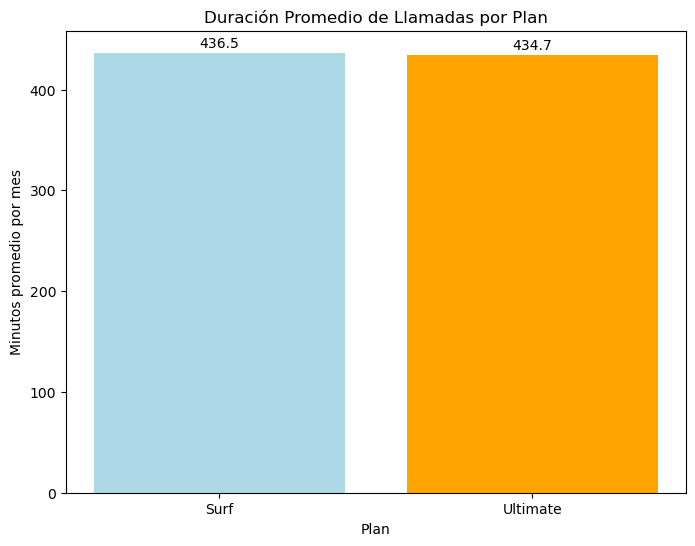

In [17]:
# Compare the average call duration for each plan and for each month. Create a bar chart to visualize this.

print("=== ESTADÍSTICAS DE MINUTOS POR PLAN ===")
print("\nPlan Surf:")
surf_minutos = consumo_completo_plan[consumo_completo_plan['plan'] == 'surf']['minutos']
print(f"Media: {surf_minutos.mean():.2f} minutos")
print(f"Mediana: {surf_minutos.median():.2f} minutos")
print(f"Desviación estándar: {surf_minutos.std():.2f} minutos")

print("\nPlan Ultimate:")
ultimate_minutos = consumo_completo_plan[consumo_completo_plan['plan'] == 'ultimate']['minutos']
print(f"Media: {ultimate_minutos.mean():.2f} minutos")
print(f"Mediana: {ultimate_minutos.median():.2f} minutos")
print(f"Desviación estándar: {ultimate_minutos.std():.2f} minutos")


plt.figure(figsize=(8, 6))
planes = ['Surf', 'Ultimate']
promedios = [surf_minutos.mean(), ultimate_minutos.mean()]

plt.bar(planes, promedios, color=['lightblue', 'orange'])
plt.title('Duración Promedio de Llamadas por Plan')
plt.ylabel('Minutos promedio por mes')
plt.xlabel('Plan')
for i, v in enumerate(promedios):
    plt.text(i, v + 5, f'{v:.1f}', ha='center')
plt.show()

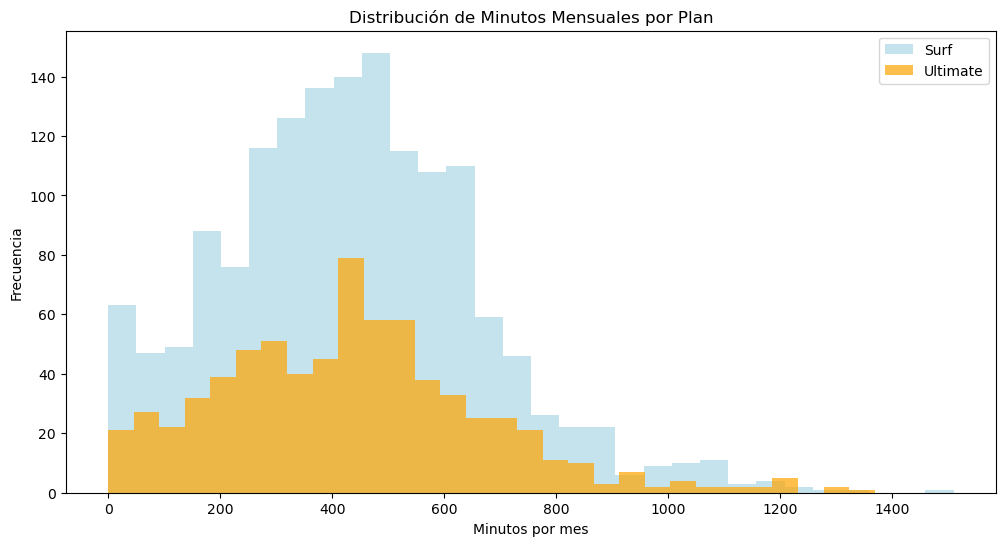

In [18]:
# Compare the number of monthly minutes needed by users of each plan. Plot a histogram.
# Histogram to compare monthly minutes by plan
plt.figure(figsize=(12, 6))

# Create subplots for better comparison
plt.hist(surf_minutos, bins=30, alpha=0.7, color='lightblue', label='Surf')
plt.hist(ultimate_minutos, bins=30, alpha=0.7, color='orange', label='Ultimate')
plt.title('Distribución de Minutos Mensuales por Plan')
plt.xlabel('Minutos por mes')
plt.ylabel('Frecuencia')
plt.legend(['Surf', 'Ultimate'])
plt.show()

In [19]:
# Calculate complete descriptive statistics of monthly call duration 
print("=== ESTADÍSTICAS COMPLETAS DE MINUTOS POR PLAN ===")

print("\nPlan Surf:")
surf_minutos = consumo_completo_plan[consumo_completo_plan['plan'] == 'surf']['minutos']
print(f"Media: {surf_minutos.mean():.2f} minutos")
print(f"Mediana: {surf_minutos.median():.2f} minutos")
print(f"Varianza: {surf_minutos.var():.2f} minutos²")
print(f"Desviación estándar: {surf_minutos.std():.2f} minutos")
print(f"Percentil 25: {surf_minutos.quantile(0.25):.2f} minutos")
print(f"Percentil 75: {surf_minutos.quantile(0.75):.2f} minutos")

print("\nPlan Ultimate:")
ultimate_minutos = consumo_completo_plan[consumo_completo_plan['plan'] == 'ultimate']['minutos']
print(f"Media: {ultimate_minutos.mean():.2f} minutos")
print(f"Mediana: {ultimate_minutos.median():.2f} minutos")
print(f"Varianza: {ultimate_minutos.var():.2f} minutos²")
print(f"Desviación estándar: {ultimate_minutos.std():.2f} minutos")
print(f"Percentil 25: {ultimate_minutos.quantile(0.25):.2f} minutos")
print(f"Percentil 75: {ultimate_minutos.quantile(0.75):.2f} minutos")

=== ESTADÍSTICAS COMPLETAS DE MINUTOS POR PLAN ===

Plan Surf:
Media: 436.52 minutos
Mediana: 430.00 minutos
Varianza: 52571.06 minutos²
Desviación estándar: 229.28 minutos
Percentil 25: 279.00 minutos
Percentil 75: 579.00 minutos

Plan Ultimate:
Media: 434.68 minutos
Mediana: 425.00 minutos
Varianza: 56573.63 minutos²
Desviación estándar: 237.85 minutos
Percentil 25: 263.00 minutos
Percentil 75: 566.00 minutos


=== Después cambiar NaN a 0 ===
Surf NaN restantes: 0
Ultimate NaN restantes: 0
Cantidad de minutos Surf: 1573
Cantidad de minutos Ultimate: 720


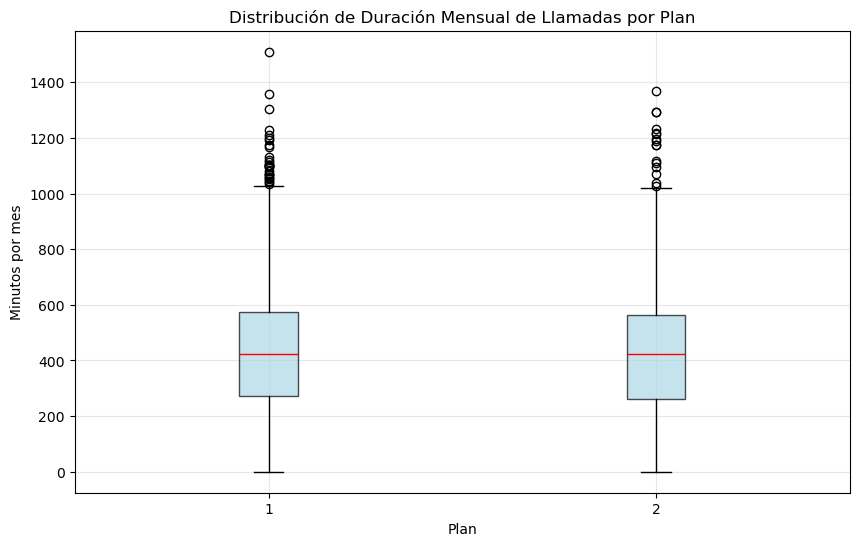

In [21]:
# Use of a box plot graf to visualize the distribution of monthly call duration
surf_minutos_clean = surf_minutos.fillna(0)
ultimate_minutos_clean = ultimate_minutos.fillna(0)

# Verify NaN cleaning
print("=== Después cambiar NaN a 0 ===") #hibo que cambiar con fillna valores que saleian NaN por que los usuaros no habian usado las llamdas esos meses por valor 0.
print(f"Surf NaN restantes: {surf_minutos_clean.isna().sum()}")
print(f"Ultimate NaN restantes: {ultimate_minutos_clean.isna().sum()}")
print(f"Cantidad de minutos Surf: {len(surf_minutos_clean)}")
print(f"Cantidad de minutos Ultimate: {len(ultimate_minutos_clean)}")

# Box plot monthly duration calls
plt.figure(figsize=(10, 6))

# Usar los datos limpios
data_to_plot = [surf_minutos_clean, ultimate_minutos_clean]
labels = ['Surf', 'Ultimate']

plt.boxplot(data_to_plot, 
            label=labels, 
            patch_artist=True,
            boxprops=dict(facecolor='lightblue',
            alpha=0.7),
            medianprops=dict(color='red', 
            linewidth=1))

plt.title('Distribución de Duración Mensual de Llamadas por Plan')
plt.ylabel('Minutos por mes')
plt.xlabel('Plan')
plt.grid(True, alpha=0.3)
plt.show()

=== ESTADÍSTICAS DE MENSAJES POR PLAN ===

Plan Surf:
Media: 40.11 mensajes
Mediana: 32.00 mensajes
Desviación estándar: 33.04 mensajes

Plan Ultimate:
Media: 46.30 mensajes
Mediana: 41.00 mensajes
Desviación estándar: 32.94 mensajes


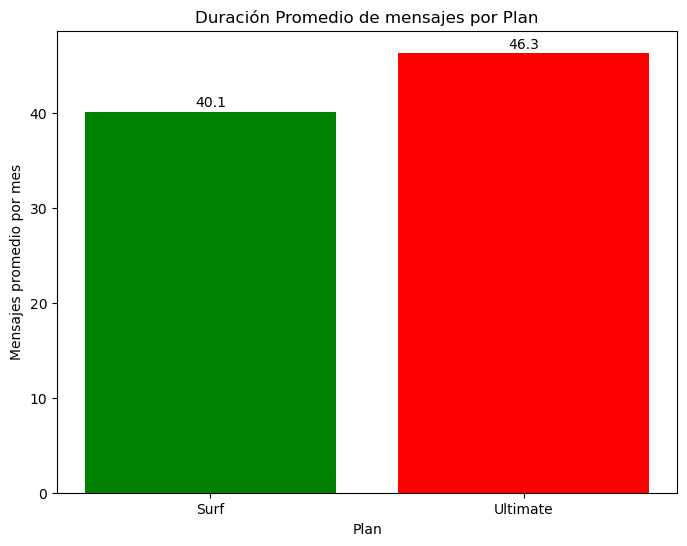

In [22]:
# Compare the number of messages that users of each plan tend to send each month.
print("=== ESTADÍSTICAS DE MENSAJES POR PLAN ===")
print("\nPlan Surf:")
surf_mensajes = consumo_completo_plan[consumo_completo_plan['plan'] == 'surf']['mensajes']
print(f"Media: {surf_mensajes.mean():.2f} mensajes")
print(f"Mediana: {surf_mensajes.median():.2f} mensajes")
print(f"Desviación estándar: {surf_mensajes.std():.2f} mensajes")

print("\nPlan Ultimate:")
ultimate_mensajes = consumo_completo_plan[consumo_completo_plan['plan'] == 'ultimate']['mensajes']
print(f"Media: {ultimate_mensajes.mean():.2f} mensajes")
print(f"Mediana: {ultimate_mensajes.median():.2f} mensajes")
print(f"Desviación estándar: {ultimate_mensajes.std():.2f} mensajes")


plt.figure(figsize=(8, 6))
planes = ['Surf', 'Ultimate']
promedios = [surf_mensajes.mean(), ultimate_mensajes.mean()]

plt.bar(planes, promedios, color=['green', 'red'])
plt.title('Duración Promedio de mensajes por Plan')
plt.ylabel('Mensajes promedio por mes')
plt.xlabel('Plan')
for i, v in enumerate(promedios):
    plt.text(i, v + 0.5, f'{v:.1f}', ha='center')
plt.show()

=== ESTADÍSTICAS DE GB POR PLAN ===

Plan Surf:
Media: 16.72 GB
Mediana: 16.92 GB
Desviación estándar: 7.88 GB

Plan Ultimate:
Media: 17.24 GB
Mediana: 16.86 GB
Desviación estándar: 7.83 GB


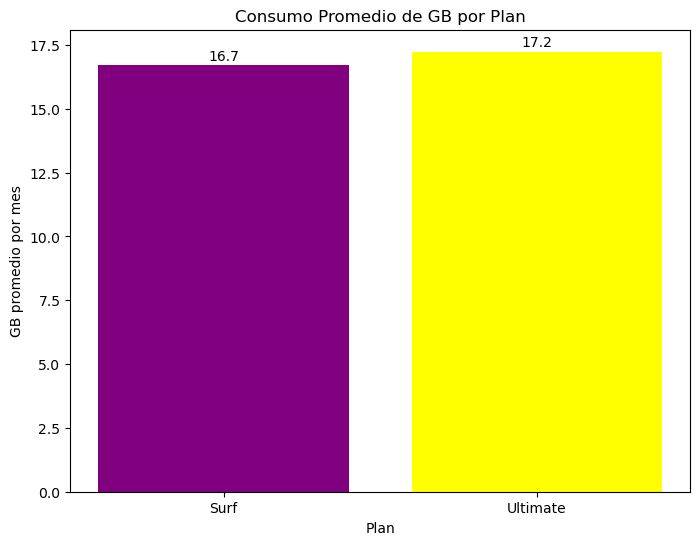

In [23]:
# Compare the amount of internet traffic consumed by users per plan

print("=== ESTADÍSTICAS DE GB POR PLAN ===")
print("\nPlan Surf:")
surf_gb = consumo_completo_plan[consumo_completo_plan['plan'] == 'surf']['gb_usados']
print(f"Media: {surf_gb.mean():.2f} GB")
print(f"Mediana: {surf_gb.median():.2f} GB")
print(f"Desviación estándar: {surf_gb.std():.2f} GB")

print("\nPlan Ultimate:")
ultimate_gb = consumo_completo_plan[consumo_completo_plan['plan'] == 'ultimate']['gb_usados']
print(f"Media: {ultimate_gb.mean():.2f} GB")
print(f"Mediana: {ultimate_gb.median():.2f} GB")
print(f"Desviación estándar: {ultimate_gb.std():.2f} GB")

plt.figure(figsize=(8, 6))
planes = ['Surf', 'Ultimate']
promedios = [surf_gb.mean(), ultimate_gb.mean()]

plt.bar(planes, promedios, color=['purple', 'yellow'])
plt.title('Consumo Promedio de GB por Plan')
plt.ylabel('GB promedio por mes')
plt.xlabel('Plan')
for i, v in enumerate(promedios):
    plt.text(i, v + 0.2, f'{v:.1f}', ha='center')
plt.show()

## Conclusions about user behavior regarding messages. Does their behavior vary depending on the plan? 

There are no atypical variations in what would be expected, nor in user usage of the messaging service; both averages are very similar, with Surf and Ultimate averages of 40.1 and 46.3, respectively. There is a 15% increase in Ultimate usage compared to Surf, and given that the plans offer 50 messages for Surf and 1,000 for Ultimate, this 15% increase is not significant. This is due to a poor sales strategy, as many Ultimate plan users never use even close to 200 messages per month, paying for an amount they don't consume. Conversely, less than half the percentage of Surf plan users do use more than the 50 messages included in the plan, with rare exceptions exceeding 250 messages per month.

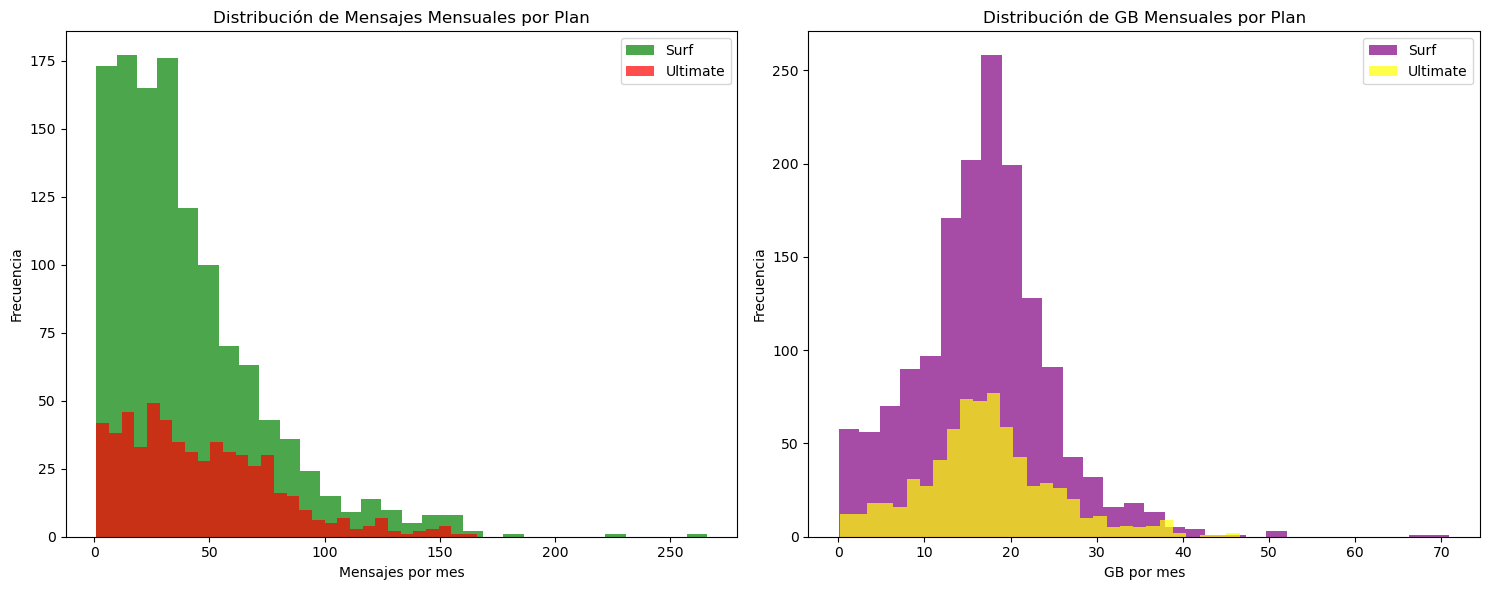

In [28]:
plt.figure(figsize=(15, 6))

# Subplot para mensajes
plt.subplot(1, 2, 1)
plt.hist(surf_mensajes, bins=30, alpha=0.7, color='green', label='Surf')
plt.hist(ultimate_mensajes, bins=30, alpha=0.7, color='red', label='Ultimate')
plt.title('Distribución de Mensajes Mensuales por Plan')
plt.xlabel('Mensajes por mes')
plt.ylabel('Frecuencia')
plt.legend(['Surf', 'Ultimate'])

# Subplot para GB de internet
plt.subplot(1, 2, 2)
plt.hist(surf_gb, bins=30, alpha=0.7, color='purple', label='Surf')
plt.hist(ultimate_gb, bins=30, alpha=0.7, color='yellow', label='Ultimate')
plt.title('Distribución de GB Mensuales por Plan')
plt.xlabel('GB por mes')
plt.ylabel('Frecuencia')
plt.legend(['Surf', 'Ultimate'])

plt.tight_layout()
plt.show()


Estadística de consumos extras de los 3 servicios:
           count       mean        std   min   25%      50%      75%  \
plan                                                                   
surf      1573.0  58.527695  55.127406  20.0  20.0  37.6437  78.4915   
ultimate   720.0  72.166866  11.027300  70.0  70.0  70.0000  70.0000   

                max  
plan                 
surf      596.08590  
ultimate  181.12731  

Estadística de consumos extras de llamadas:
           count     mean       std  min  25%  50%   75%   max
plan                                                          
surf      1573.0  1.84377  3.765744  0.0  0.0  0.0  2.28  30.3
ultimate   720.0  0.00000  0.000000  0.0  0.0  0.0  0.00   0.0

Estadística de consumos extras de mensajes:
           count      mean       std  min  25%  50%  75%   max
plan                                                          
surf      1573.0  0.210381  0.584127  0.0  0.0  0.0  0.0  6.48
ultimate   720.0  0.000000  0.000000  0.

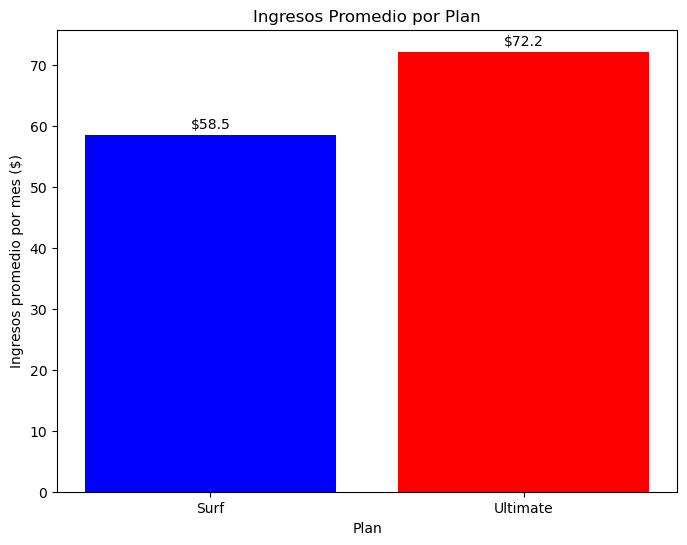

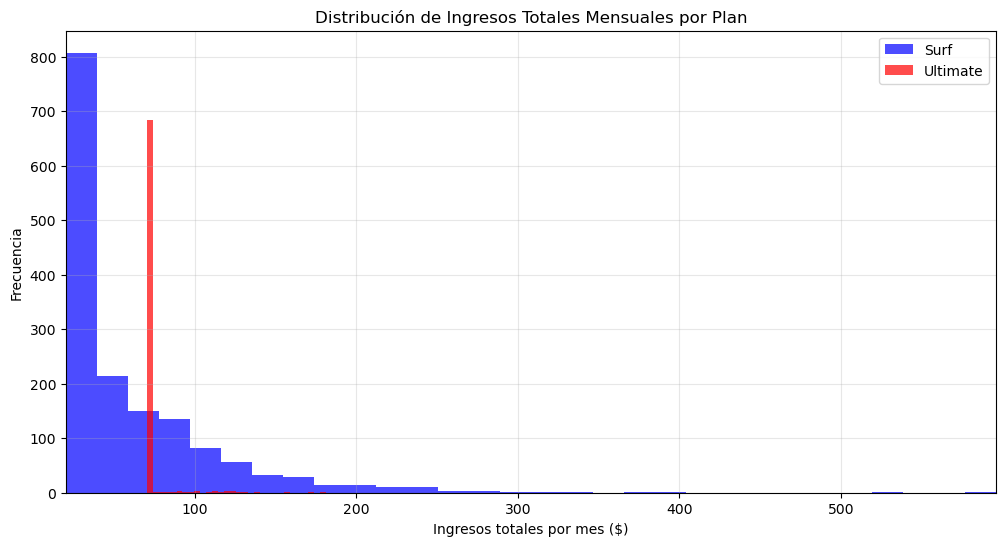

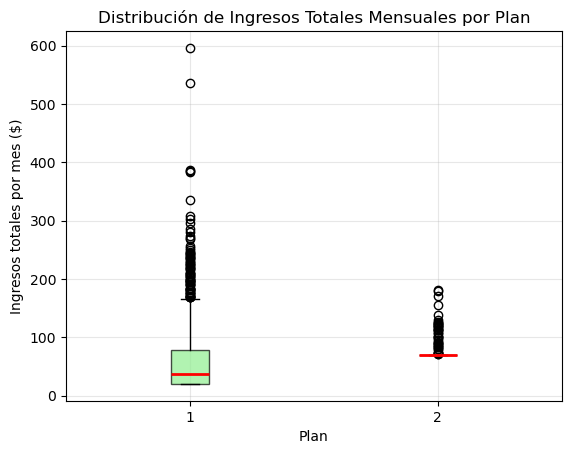

In [30]:
#Description of revenue behavior based on total plan revenue + extra services (minutes, messages and internet)
print()
print("Estadística de consumos extras de los 3 servicios:")
print(consumo_completo_plan.groupby("plan")["ingreso_total"].describe())
#Descripción de los ingresos extras por cada servicio por separado
print()
print("Estadística de consumos extras de llamadas:")
print(consumo_completo_plan.groupby("plan")["ingreso_extra_llamadas"].describe())
print()
print("Estadística de consumos extras de mensajes:")
print(consumo_completo_plan.groupby("plan")["ingreso_extra_mensajes"].describe())
print()
print("Estadística de consumos extras de internet:")
print(consumo_completo_plan.groupby("plan")["ingreso_extra_internet"].describe())
print()
print("% de Usuarios por plan")
print(consumo_completo_plan.groupby("plan").size()/len(consumo_completo_plan)*100)


print("=== ESTADÍSTICAS DE INGRESOS TOTALES POR PLAN ===")
print("\nPlan Surf:")
surf_ingresos = consumo_completo_plan[consumo_completo_plan['plan'] == 'surf']['ingreso_total']
print(f"Media: ${surf_ingresos.mean():.2f}")
print(f"Mediana: ${surf_ingresos.median():.2f}")
print(f"Desviación estándar: ${surf_ingresos.std():.2f}")

print("\nPlan Ultimate:")
ultimate_ingresos = consumo_completo_plan[consumo_completo_plan['plan'] == 'ultimate']['ingreso_total']
print(f"Media: ${ultimate_ingresos.mean():.2f}")
print(f"Mediana: ${ultimate_ingresos.median():.2f}")
print(f"Desviación estándar: ${ultimate_ingresos.std():.2f}")

plt.figure(figsize=(8, 6))
planes = ['Surf', 'Ultimate']
promedios = [surf_ingresos.mean(), ultimate_ingresos.mean()]

plt.bar(planes, promedios, color=['blue', 'red'])
plt.title('Ingresos Promedio por Plan')
plt.ylabel('Ingresos promedio por mes ($)')
plt.xlabel('Plan')
for i, v in enumerate(promedios):
    plt.text(i, v + 1, f'${v:.1f}', ha='center')
plt.show()


# Crear histograma para comparar ingresos totales por plan
plt.figure(figsize=(12, 6))
plt.hist(surf_ingresos, bins=30, alpha=0.7, color='blue')
plt.hist(ultimate_ingresos, bins=30, alpha=0.7, color='red')


# Configurar el rango del eje x para empezar en $20
plt.xlim(20, surf_ingresos.max())

plt.title('Distribución de Ingresos Totales Mensuales por Plan')
plt.xlabel('Ingresos totales por mes ($)')
plt.ylabel('Frecuencia')
plt.legend(['Surf', 'Ultimate', 'Plan base Surf ($20)', 'Plan base Ultimate ($70)'])
plt.grid(True, alpha=0.3)
plt.show()

# Diagrama de boxplot para ingresos por planes 
data_to_plot = [surf_ingresos, ultimate_ingresos]
labels = ['Surf', 'Ultimate']

plt.boxplot(data_to_plot, 
            label=labels, 
            patch_artist=True,
            boxprops=dict(facecolor='lightgreen',
            alpha=0.7),
            medianprops=dict(color='red', 
            linewidth=2))

plt.title('Distribución de Ingresos Totales Mensuales por Plan')
plt.ylabel('Ingresos totales por mes ($)')
plt.xlabel('Plan')
plt.grid(True, alpha=0.3)
plt.show()

## Conclusions on how revenue differs between plans.

Regarding the revenue difference between the Surf and Ultimate plans, we can observe that the average for the Ultimate plan, \$72.2 USD, is very close to the plan cost of \$70 USD/month and is equal to the median. In contrast, the Surf plan costs \$20 USD/month, and the mean and median jump to \$58.15 and \$36.89 USD, respectively. This reveals a poor selection of plan offerings by the marketing/sales management, as they are not offering a plan that meets customer needs. In the case of the Surf plan, the plan's features are insufficient, resulting in a large number of customers paying much more than they originally agreed to for extra services. This generates significant user dissatisfaction. It would be relevant to consider an intermediate plan between the two to ensure consistent demand and loyalty through greater customer satisfaction. And there would also be a percentage of the Ultimate plan that doesn't require as many of the 3 services, which would be a better fit for them.

In [32]:
# Test the hypotheses

# === PRIMERA HIPÓTESIS: DIFERENCIA DE INGRESOS ENTRE PLANES ===

print("=== FORMULACIÓN DE HIPÓTESIS ===")
print("H₀ (Hipótesis nula): Los ingresos promedio de los planes Surf y Ultimate son iguales")
print("H₁ (Hipótesis alternativa): Los ingresos promedio de los planes Surf y Ultimate son diferentes")
print("Nivel de significancia: α = 0.05")
print()

# Preparar los datos
surf = consumo_completo_plan[consumo_completo_plan["plan"] == "surf"]["ingreso_total"]
ultimate = consumo_completo_plan[consumo_completo_plan["plan"] == "ultimate"]["ingreso_total"]

print("=== VERIFICACIÓN DE SUPUESTOS ===")
print("Antes de aplicar el t-test, verificamos si las varianzas son similares:")

# Prueba de Levene para igualdad de varianzas
from scipy.stats import levene
levene_stat, levene_p = levene(surf, ultimate)
print(f"Prueba de Levene - Estadístico: {levene_stat:.4f}, p-valor: {levene_p:.4f}")

# Determinar si usar equal_var=True o False
if levene_p > 0.05:
    equal_var = True
    print("Las varianzas son similares (p > 0.05) → Usaremos equal_var=True")
else:
    equal_var = False
    print("Las varianzas son diferentes (p ≤ 0.05) → Usaremos equal_var=False")

print()
print("=== JUSTIFICACIÓN DEL TEST ELEGIDO ===")
print("Elegimos el t-test de dos muestras independientes porque:")
print("1. Comparamos las medias de dos grupos independientes (Surf vs Ultimate)")
print("2. Ambas muestras tienen tamaños suficientemente grandes (n > 30)")
print("3. Los datos son aproximadamente normales (por el Teorema del Límite Central)")
print()

# Realizar el t-test con el parámetro correcto
alpha = 0.05
results = st.ttest_ind(surf, ultimate, equal_var=equal_var)

print("=== RESULTADOS DEL TEST ===")
print(f"Estadístico t: {results.statistic:.4f}")
print(f"Valor p: {results.pvalue:.2e}")
print()

# Interpretación
if results.pvalue < alpha:
    print("=== CONCLUSIÓN ===")
    print("✅ RECHAZAMOS la hipótesis nula")
    print(f"Con un 95% de confianza, podemos afirmar que los ingresos promedio")
    print(f"de los planes Surf (${surf.mean():.2f}) y Ultimate (${ultimate.mean():.2f}) son significativamente diferentes.")
else:
    print("=== CONCLUSIÓN ===")
    print("❌ NO RECHAZAMOS la hipótesis nula")
    print("No hay evidencia suficiente para afirmar que los ingresos promedio son diferentes.")

=== FORMULACIÓN DE HIPÓTESIS ===
H₀ (Hipótesis nula): Los ingresos promedio de los planes Surf y Ultimate son iguales
H₁ (Hipótesis alternativa): Los ingresos promedio de los planes Surf y Ultimate son diferentes
Nivel de significancia: α = 0.05

=== VERIFICACIÓN DE SUPUESTOS ===
Antes de aplicar el t-test, verificamos si las varianzas son similares:
Prueba de Levene - Estadístico: 365.0460, p-valor: 0.0000
Las varianzas son diferentes (p ≤ 0.05) → Usaremos equal_var=False

=== JUSTIFICACIÓN DEL TEST ELEGIDO ===
Elegimos el t-test de dos muestras independientes porque:
1. Comparamos las medias de dos grupos independientes (Surf vs Ultimate)
2. Ambas muestras tienen tamaños suficientemente grandes (n > 30)
3. Los datos son aproximadamente normales (por el Teorema del Límite Central)

=== RESULTADOS DEL TEST ===
Estadístico t: -9.4099
Valor p: 1.44e-20

=== CONCLUSIÓN ===
✅ RECHAZAMOS la hipótesis nula
Con un 95% de confianza, podemos afirmar que los ingresos promedio
de los planes Surf 

In [33]:
ciudades = consumo_completo_plan["city"].unique()
print("Ciudades disponibles:")
print(ciudades)

ciudades_ny_nj = [ciudad for ciudad in ciudades if "NY" in ciudad or "NJ" in ciudad]
print()
print("Ciudades NY-NJ encontradas:")
print(ciudades_ny_nj)

Ciudades disponibles:
['Atlanta-Sandy Springs-Roswell, GA MSA' 'Seattle-Tacoma-Bellevue, WA MSA'
 'Las Vegas-Henderson-Paradise, NV MSA' 'Tulsa, OK MSA'
 'Dallas-Fort Worth-Arlington, TX MSA'
 'San Francisco-Oakland-Berkeley, CA MSA' 'Grand Rapids-Kentwood, MI MSA'
 'Orlando-Kissimmee-Sanford, FL MSA'
 'San Jose-Sunnyvale-Santa Clara, CA MSA' 'Cleveland-Elyria, OH MSA'
 'Chicago-Naperville-Elgin, IL-IN-WI MSA' 'Knoxville, TN MSA'
 'New York-Newark-Jersey City, NY-NJ-PA MSA' 'Pittsburgh, PA MSA'
 'Fresno, CA MSA' 'Washington-Arlington-Alexandria, DC-VA-MD-WV MSA'
 'Indianapolis-Carmel-Anderson, IN MSA' 'Jacksonville, FL MSA'
 'Los Angeles-Long Beach-Anaheim, CA MSA'
 'Omaha-Council Bluffs, NE-IA MSA'
 'Houston-The Woodlands-Sugar Land, TX MSA'
 'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA'
 'Tampa-St. Petersburg-Clearwater, FL MSA' 'Birmingham-Hoover, AL MSA'
 'Oklahoma City, OK MSA' 'Charlotte-Concord-Gastonia, NC-SC MSA'
 'Denver-Aurora-Lakewood, CO MSA'
 'Nashville-Davidson–Murfr

In [35]:
# Test the hypothesis that the average income of users in NY and NJ is different 

# Separación de los datos por grupos geográficos
ingresos_NY_NJ = consumo_completo_plan[consumo_completo_plan["city"].isin(ciudades_ny_nj)]["ingreso_total"]
ingresos_resto_lugares = consumo_completo_plan[~consumo_completo_plan["city"].isin(ciudades_ny_nj)]["ingreso_total"]

print("=== PRUEBA DE HIPÓTESIS: INGRESOS POR REGIÓN ===\n")

# Formulación de hipótesis
print("HIPÓTESIS:")
print("H₀ (hipótesis nula): μ_NY_NJ = μ_otras_regiones")
print("    Los ingresos promedio de usuarios en NY-NJ son iguales a los de otras regiones")
print("H₁ (hipótesis alternativa): μ_NY_NJ ≠ μ_otras_regiones") 
print("    Los ingresos promedio de usuarios en NY-NJ son diferentes a los de otras regiones\n")

# Estadísticas descriptivas
print("ESTADÍSTICAS DESCRIPTIVAS:")
print(f"Ingresos NY-NJ: n={len(ingresos_NY_NJ)}, media=${ingresos_NY_NJ.mean():.2f}, std=${ingresos_NY_NJ.std():.2f}")
print(f"Ingresos otras regiones: n={len(ingresos_resto_lugares)}, media=${ingresos_resto_lugares.mean():.2f}, std=${ingresos_resto_lugares.std():.2f}\n")

# Configuración de la prueba
alpha = 0.05  # Nivel de significancia del 5% (confianza del 95%)
print(f"CONFIGURACIÓN DE LA PRUEBA:")
print(f"Nivel de significancia (α): {alpha}")
print(f"Tipo de prueba: Prueba t de Student para muestras independientes (dos colas)\n")

# Realización de la prueba
results = st.ttest_ind(ingresos_NY_NJ, ingresos_resto_lugares)

print("RESULTADOS DE LA PRUEBA:")
print(f"Estadístico t: {results.statistic:.4f}")
print(f"Valor p: {results.pvalue:.6f}\n")

# Interpretación de resultados
print("DECISIÓN E INTERPRETACIÓN:")
if results.pvalue < alpha:
    print(f"Como p-value ({results.pvalue:.6f}) < α ({alpha}), RECHAZAMOS la hipótesis nula.")
    print("Conclusión: Existe evidencia estadísticamente significativa de que los ingresos promedio")
    print("de usuarios en NY-NJ son diferentes a los de otras regiones.")
else:
    print(f"Como p-value ({results.pvalue:.6f}) ≥ α ({alpha}), NO PODEMOS RECHAZAR la hipótesis nula.")
    print("Conclusión: No hay evidencia estadísticamente significativa de diferencia")
    print("en los ingresos promedio entre usuarios de NY-NJ y otras regiones.")

print(f"\nCon un nivel de confianza del {(1-alpha)*100}%, podemos afirmar que esta conclusión es estadísticamente válida.")

=== PRUEBA DE HIPÓTESIS: INGRESOS POR REGIÓN ===

HIPÓTESIS:
H₀ (hipótesis nula): μ_NY_NJ = μ_otras_regiones
    Los ingresos promedio de usuarios en NY-NJ son iguales a los de otras regiones
H₁ (hipótesis alternativa): μ_NY_NJ ≠ μ_otras_regiones
    Los ingresos promedio de usuarios en NY-NJ son diferentes a los de otras regiones

ESTADÍSTICAS DESCRIPTIVAS:
Ingresos NY-NJ: n=488, media=$59.71, std=$45.50
Ingresos otras regiones: n=1805, media=$63.65, std=$46.75

CONFIGURACIÓN DE LA PRUEBA:
Nivel de significancia (α): 0.05
Tipo de prueba: Prueba t de Student para muestras independientes (dos colas)

RESULTADOS DE LA PRUEBA:
Estadístico t: -1.6585
Valor p: 0.097355

DECISIÓN E INTERPRETACIÓN:
Como p-value (0.097355) ≥ α (0.05), NO PODEMOS RECHAZAR la hipótesis nula.
Conclusión: No hay evidencia estadísticamente significativa de diferencia
en los ingresos promedio entre usuarios de NY-NJ y otras regiones.

Con un nivel de confianza del 95.0%, podemos afirmar que esta conclusión es estadí

# Conclusions 
In this final analysis of the Megaline case and its Surf and Ultimate plans, what we can see with the hypotheses analyzed in this section is that in the first case they confirm that theres is an important price distinction but probabl

Final Conclusion - Profitability Recommendation
The Surf plan is more profitable for Megaline for the following key reasons:

Profitability Analysis:
1. Revenue per User:
- Surf Plan: $58.15 average monthly vs. $20 for the base plan
- Ultimate Plan: $72.17 average monthly vs. $70 for the base plan
- Profit Margin: Surf generates 190% more than its base price, Ultimate only 3% more

2. Market Share:
- Surf: 68.6% of users (higher demand)
- Ultimate: 31.4% of users
- Total Volume: Surf generates more total revenue due to its larger user base

3. Consumption Behavior:
- Users of both plans consume similar amounts (minutes: ~410, messages: ~40-46, GB: ~16-17)
- Surf users consistently exceed limits, generating significant additional revenue
- Ultimate users They rarely exceed their generous limits.

Strategic Recommendation:
Prioritize promoting the Surf plan because:

It generates higher profitability per user ($38.15 extra profit vs. $2.17)
It has higher market demand
Users are willing to pay for additional services
Additional Consideration: Evaluate creating an intermediate plan between Surf and Ultimate to capture users who significantly exceed Surf's limits but don't need Ultimate's full capacity.

While it's important to look at profitability data, it can't be sustainable in the long term if user needs aren't considered. Perhaps having an intermediate plan that better suits the consumption patterns of most users could result in a happier customer base with greater brand loyalty.